In [2]:
!pip install tflearn

In [0]:
from __future__ import division, print_function, absolute_import

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import tflearnfrom tflearn.data_utils import shuffle, to_categorical
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation

from tflearn.data_utils import shuffle, to_categorical
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation


In [0]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [5]:
!pip install pydrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [7]:
from pydrive.drive import GoogleDrive

drive = GoogleDrive(gauth) # Create GoogleDrive instance with authenticated GoogleAuth instance

# Auto-iterate through all files in the root folder.
file_list = drive.ListFile({'q': "'1vQhQXjy4X9woILOTXeY3C-tz14xJkBQE' in parents and trashed=false"}).GetList()
for file1 in file_list:
  if file1['title'] == 'train.pkl':
     PIK = file1['id']
     print('title: %s, id: %s' % (file1['title'], file1['id']))
  elif file1['title'] == 'validation.pkl':
     VALIDPIK = file1['id']
     print('title: %s, id: %s' % (file1['title'], file1['id']))
  elif file1['title'] == 'test.pkl':
     TESTPIK = file1['id']
     print('title: %s, id: %s' % (file1['title'], file1['id']))


title: train.pkl, id: 13rbDW4JpED4Q97AOe1WquZCLCHWb7aI0
title: validation.pkl, id: 1wNCJDiwVMnoIL4alHl9De08b337WiEZP
title: test.pkl, id: 1gSKWAsH9YND3Y3_vNrXeXa-KRiPEGqBS


In [0]:
import pickle

In [0]:
X = []
Y = []
X_validate = []
Y_validate = []
X_test = []
Y_test = []

label_pairs ={
    'adho_mukha_svanasana':1,
    'bharadvajasana':2,
    'pasasana':3,
    'salamba_sarvangasana':4,
    'salamba_sirsasana':5,
    'virabhadrasana_I':6,
    'virabhadrasana_II':7,
    'virabhadrasana_III':8
}


In [0]:
dataFile = drive.CreateFile({'id': PIK}).GetContentFile('train.pkl')

In [0]:
testFile = drive.CreateFile({'id': TESTPIK}).GetContentFile('test.pkl')

In [0]:
validateFile = drive.CreateFile({'id': VALIDPIK}).GetContentFile('validation.pkl')

In [13]:

X_type = 'float64'

with open('train.pkl', "rb") as f:
    while True :
        try:
            record=pickle.load(f)
            X.append(record[0].astype(X_type))
            Y.append(label_pairs[record[1]])
        except EOFError:
            print('processing done!')
            break
            
print ("Train Data Size :" , len(X))


processing done!
Train Data Size : 6180


In [14]:
with open('validation.pkl', "rb") as f:
    while True :
        try:
            record=pickle.load(f)
            X_validate.append(record[0].astype(X_type))
            Y_validate.append(label_pairs[record[1]])
        except EOFError:
            print('processing done!')
            break
            
print ("Validation Data Size :" , len(X_validate))

processing done!
Validation Data Size : 1330


In [15]:
with open('test.pkl', "rb") as f:
    while True :
        try:
            record=pickle.load(f)
            X_test.append(record[0].astype(X_type))
            Y_test.append(label_pairs[record[1]])
        except EOFError:
            print('processing done!')
            break
            
print ("Test Data Size :" , len(X_test))


processing done!
Test Data Size : 265


In [0]:
model_name="convnet_v0.2_skeletal_insights"

In [17]:
#convert to categorical variables
Y = to_categorical(Y, 9)
Y_validate = to_categorical(Y_validate, 9)
Y_test = to_categorical(Y_test, 9)

from __future__ import division, print_function, absolute_import

import tflearn

# Real-time data preprocessing
img_prep = tflearn.ImagePreprocessing()
img_prep.add_featurewise_zero_center(per_channel=True)

# Real-time data augmentation
img_aug = tflearn.ImageAugmentation()
img_aug.add_random_flip_leftright()
img_aug.add_random_blur()
img_aug.add_random_crop([64, 64], padding=4)


# Input is a 32x32 image with 3 color channels (red, green and blue)
network = input_data(shape=[None, 64, 64, 3],
                     data_preprocessing=img_prep,
                     data_augmentation=img_aug)

# Step 1: Convolution
network = conv_2d(network, 64, 3, activation='relu')

# Step 2: Max pooling
network = max_pool_2d(network, 2)

# Step 3: Convolution again
network = conv_2d(network, 128, 3, activation='relu')

# Step 4: Convolution yet again
network = conv_2d(network, 128, 3, activation='relu')

# Step 5: Max pooling again
network = max_pool_2d(network, 2)

# Step 6: Convolution yet again
network = conv_2d(network, 128, 3, activation='relu')

# Step 7: Max pooling again
network = max_pool_2d(network, 2)

# Step 8: Fully-connected 512 node neural network
network = fully_connected(network, 512, activation='relu')

# Step 9: Dropout - throw away some data randomly during training to prevent over-fitting
network = dropout(network, 0.5)

# Step 10: Fully-connected neural network with two outputs (0=isn't a bird, 1=is a bird) to make the final prediction
network = fully_connected(network, 9, activation='softmax')

# Tell tflearn how we want to train the network
network = regression(network, optimizer='adam',
                     loss='categorical_crossentropy',
                     learning_rate=0.001)


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


In [18]:
# Training

start_time = time.time()

model = tflearn.DNN(network, checkpoint_path=('.forever/'+model_name+'.ckpt'))

model.fit(X, Y, n_epoch=50, shuffle=True, validation_set=(X_validate, Y_validate),
              show_metric=True, batch_size=96,
              snapshot_epoch=True,
              run_id=model_name)

Training Step: 3249  | total loss: 20.23823 | time: 6.721s
| Adam | epoch: 050 | loss: 20.23823 - acc: 0.1211 -- iter: 6144/6180
Training Step: 3250  | total loss: 20.10925 | time: 7.831s
| Adam | epoch: 050 | loss: 20.10925 - acc: 0.1267 | val_loss: 20.42895 - val_acc: 0.1128 -- iter: 6180/6180
--
INFO:tensorflow:/content/.forever/convnet_v0.2_skeletal_insights.ckpt-3250 is not in all_model_checkpoint_paths. Manually adding it.


In [19]:
 model.save(model_name)
 print("Network trained and saved as "+model_name+" time taken: " , time.time() - start_time)



INFO:tensorflow:/content/convnet_v0.2_skeletal_insights is not in all_model_checkpoint_paths. Manually adding it.
Network trained and saved as convnet_v0.2_skeletal_insights time taken:  422.2951331138611


In [20]:
#Predicting

test_images_and_labels = list(zip(X_test, Y_test))
correct_count = 0
wrong_count = 0
correct_indices = []
wrong_indices = []
preds = []
labels = []
total_predict_time = 0 ;

for index, (image, label) in enumerate(test_images_and_labels):
    imagedata = image[np.newaxis, :, :]
    predict_start_time = time.time()
    pred = model.predict(imagedata)
    total_predict_time=total_predict_time+(time.time()-predict_start_time)
    pred = pred[0].argmax(axis=0)
    label = label.argmax(axis=0)
    #print("Pred: {pred} Actual:{label}".format(pred=pred, label=label) )
    #print(int(pred))
    #print(int(label))
    preds = np.append(preds,pred)
    labels = np.append(labels,label)
    if int(pred) == int(label) :
        correct_count=correct_count+1
        correct_indices = np.append(correct_indices,int(index))
    else :
        wrong_count=wrong_count+1
        wrong_indices = np.append(wrong_indices,int(index))

accuracy=correct_count/(correct_count+wrong_count)
print(accuracy)
print(correct_count)
print(wrong_count)
print("Total Prediction Time :" + str(total_predict_time))


0.10566037735849057
28
237
Total Prediction Time :0.6580338478088379


In [0]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
conf_mat = np.matrix(tf.confusion_matrix(labels,preds,num_classes=8,dtype=tf.int32))
conf_mat = confusion_matrix(labels,preds)


In [0]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[28  0  0  0  0  0  0  0]
 [33  0  0  0  0  0  0  0]
 [26  0  0  0  0  0  0  0]
 [29  0  0  0  0  0  0  0]
 [43  0  0  0  0  0  0  0]
 [40  0  0  0  0  0  0  0]
 [38  0  0  0  0  0  0  0]
 [28  0  0  0  0  0  0  0]]
Confusion matrix, without normalization
[[28  0  0  0  0  0  0  0]
 [33  0  0  0  0  0  0  0]
 [26  0  0  0  0  0  0  0]
 [29  0  0  0  0  0  0  0]
 [43  0  0  0  0  0  0  0]
 [40  0  0  0  0  0  0  0]
 [38  0  0  0  0  0  0  0]
 [28  0  0  0  0  0  0  0]]
Normalized confusion matrix
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]


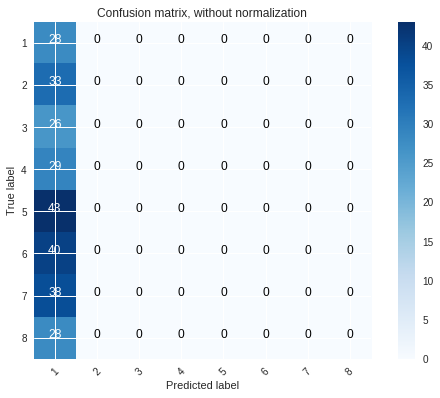

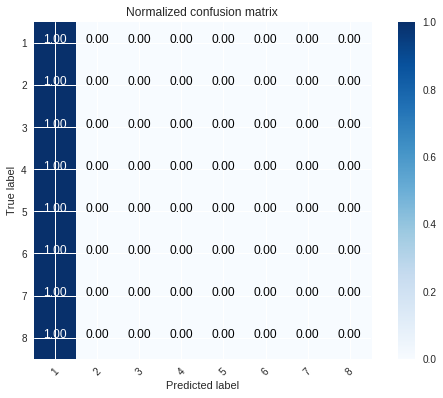

In [23]:
np.set_printoptions(threshold=np.nan)
class_names=['1','2','3','4','5','6','7','8']
print(conf_mat)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()